In [153]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import mkdir, path
from sklearn.model_selection import train_test_split


# Directory to save models.
try:
    mkdir("models")
except FileExistsError:
    pass
except Exception as e:
    print("Failed to create models directory. Reason: %s", e)
    exit(1)


DATASET_PATH = "final-merged-dataset.csv"

# Dict to store the model metrics like accuracy, f1, recall
metrics = {}


Read dataset


In [154]:
dataset = pd.read_csv(DATASET_PATH)

# Initially set the clean_dataset as dataset itself. Using two variables clean_dataset
# and dataset to retain full dataset because after cleaning dataset we lose some data.
clean_dataset = pd.read_csv(DATASET_PATH)
dataset


,frame.encap_type,frame.time_epoch,frame.len,frame.cap_len,eth.src,eth.dst,ip.version,ip.hdr_len,ip.tos,ip.id,...,ip.checksum,ip.src,ip.dst,ip.len,ip.dsfield,srcport,dstport,length,checksum,quic
0,1,1.645084e+09,84,84,28:cd:c4:75:f4:05,8c:3b:ad:d7:c6:70,4,20.0,NaN,0x585a,...,0xdc1e,192.168.1.7,74.125.250.1,70.0,0x00,54274,19305,50,0x2ce5,0
1,1,1.645084e+09,127,127,8c:3b:ad:d7:c6:70,28:cd:c4:75:f4:05,4,20.0,NaN,0x0000,...,0x2d29,172.217.163.202,192.168.1.7,113.0,0x00,443,51960,93,0xcd13,0
2,1,1.645084e+09,78,78,28:cd:c4:75:f4:05,8c:3b:ad:d7:c6:70,4,20.0,NaN,0x6693,...,0x81c6,192.168.1.7,172.217.163.202,64.0,0x00,51960,443,44,0x6696,0
3,1,1.645084e+09,159,159,8c:3b:ad:d7:c6:70,28:cd:c4:75:f4:05,4,20.0,NaN,0xfee5,...,0x7a48,74.125.250.1,192.168.1.7,145.0,0x00,19305,54274,125,0x95a1,0
4,1,1.645084e+09,67,67,8c:3b:ad:d7:c6:70,28:cd:c4:75:f4:05,4,20.0,NaN,0x0000,...,0x2d65,172.217.163.202,192.168.1.7,53.0,0x00,443,51960,33,0xee3e,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1833235,1,1.645534e+09,54,54,f8:5e:a0:dd:40:4b,9c:9d:7e:1b:50:38,4,20.0,NaN,0xd5e3,...,0x0000,192.168.31.158,23.221.32.227,40.0,0x00,49827,443,20,0x1921,0
1833236,1,1.645534e+09,66,66,9c:9d:7e:1b:50:38,f8:5e:a0:dd:40:4b,4,20.0,NaN,0x0000,...,0x5d43,52.32.33.250,192.168.31.158,52.0,0x20,443,49826,32,0xb27d,0
1833237,1,1.645534e+09,54,54,f8:5e:a0:dd:40:4b,9c:9d:7e:1b:50:38,4,20.0,NaN,0x6352,...,0x0000,192.168.31.158,52.32.33.250,40.0,0x00,49826,443,20,0x367b,0
1833238,1,1.645534e+09,263,263,f8:5e:a0:dd:40:4b,9c:9d:7e:1b:50:38,4,20.0,NaN,0x6353,...,0x0000,192.168.31.158,52.32.33.250,249.0,0x00,49826,443,20,0x374c,0


Dataset specification


Total packets: 1833240
1    1119057
0     714183
Name: quic, dtype: int64


/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


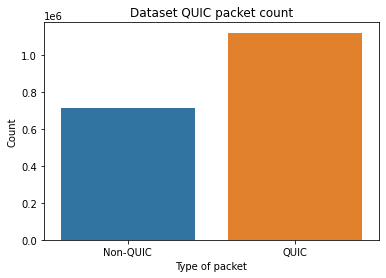

In [155]:
packet_protocol = dataset["quic"]
packet_protocol = ["QUIC" if x else "Non-QUIC" for x in packet_protocol]

print("Total packets: {0}".format(len(packet_protocol)))
print(dataset["quic"].value_counts())

chart = sns.countplot(packet_protocol)
plt.title("Dataset QUIC packet count")
plt.xlabel("Type of packet")
plt.ylabel("Count")
plt.show()


Preprocess dataset

- Extract quic column data and remove from dataset.
- Remove the string related feilds.
- Remove empty feilds


In [156]:
def preprocess(ds):

    # 1. Remove the strings columnns from dataset.
    # eth.src, eth.dst, ip.src, ip.dst, ip.tos, ip.id, ip.flags, ip.checksum, ip.dsfield, checksum
    ds.drop(
        [
            "eth.src",
            "eth.dst",
            "ip.src",
            "ip.dst",
            "ip.tos",
            "ip.id",
            "ip.flags",
            "ip.checksum",
            "ip.dsfield",
            "checksum",
        ],
        axis=1,
        inplace=True,
    )

    # 2. Remove the invalid rows ie axis=0 from the dataset.
    ds.dropna(axis=0, inplace=True)

    # 3. After deleting the rows, shuffle and delete the index column.
    ds = ds.sample(frac=1).reset_index(drop=True)

    # 4. Get the result(quic) column values and remove dataset.
    targets = list(ds["quic"].values)
    ds.drop(ds.columns[len(ds.columns) - 1], axis=1, inplace=True)

    print(ds.info())
    return ds, targets


initial_size = dataset.size
clean_dataset, targets = preprocess(clean_dataset)
final_size = clean_dataset.size

if clean_dataset.isnull().values.any():
    print("Failed to clean dataset. There are NaN/null values in dataset.")
    nan_cols = [i for i in clean_dataset.columns if clean_dataset[i].isnull().any()]
    print("Columns with null values: ", *nan_cols)
    exit(1)


print(
    "\nDataset size: {0} = {1}, Cleaned dataset size: {2} = {3}, Percentage: {4}%".format(
        dataset.shape,
        initial_size,
        clean_dataset.shape,
        final_size,
        round(100 - (final_size / initial_size) * 100, 2),
    )
)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1823522 entries, 0 to 1833239
Data columns (total 16 columns):
 #   Column            Dtype  
---  ------            -----  
 0   frame.encap_type  int64  
 1   frame.time_epoch  float64
 2   frame.len         int64  
 3   frame.cap_len     int64  
 4   ip.version        int64  
 5   ip.hdr_len        float64
 6   ip.flags.rb       float64
 7   ip.flags.df       float64
 8   ip.flags.mf       float64
 9   ip.frag_offset    float64
 10  ip.ttl            float64
 11  ip.proto          float64
 12  ip.len            float64
 13  srcport           int64  
 14  dstport           int64  
 15  length            int64  
dtypes: float64(9), int64(7)
memory usage: 236.5 MB
None

Dataset size: (1833240, 27) = 49497480, Cleaned dataset size: (1823522, 16) = 29176352, Percentage: 41.05%


Split train and test


In [157]:
X_train, X_test, Y_train, Y_test = train_test_split(
    clean_dataset, targets, test_size=0.30, random_state=7, shuffle=True
)

clean_dataset.reset_index(drop=True, inplace=True)
clean_dataset.to_csv("cleaned-dataset.csv")
clean_dataset

# prepare the cross-validation procedure
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

X = clean_dataset
Y = targets
X, Y = make_classification(
    n_samples=10000, n_features=16, n_informative=16, n_redundant=0, random_state=7
)
cv = KFold(n_splits=10, random_state=7, shuffle=True)


Size and Train data colunmns


In [158]:
print("Size of test: {0}, {1}".format(len(X_test), len(Y_test)))
print("Size of train: {0}, {1}".format(len(X_train), len(Y_train)))

X_train


Size of test: 547057, 547057
Size of train: 1276465, 1276465


,frame.encap_type,frame.time_epoch,frame.len,frame.cap_len,ip.version,ip.hdr_len,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.len,srcport,dstport,length
750278,1,1.645098e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,59.0,17.0,1278.0,443,56260,1258
202410,1,1.645085e+09,54,54,4,20.0,0.0,1.0,0.0,0.0,128.0,6.0,40.0,51775,443,20
1185006,1,1.645123e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,128.0,17.0,1278.0,64299,443,1258
470677,1,1.645095e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,122.0,17.0,1278.0,443,51078,1258
904414,1,1.645120e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,55.0,17.0,1278.0,443,54766,1258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1817653,1,1.645534e+09,443,443,4,20.0,0.0,1.0,0.0,0.0,58.0,17.0,429.0,443,64004,409
535361,1,1.645096e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,122.0,17.0,1278.0,443,53935,1258
574309,1,1.645096e+09,54,54,4,20.0,0.0,1.0,0.0,0.0,128.0,6.0,40.0,49166,443,20
1246386,1,1.645123e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,123.0,17.0,1278.0,443,65114,1258


Logistic Regression


In [159]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Fitting the logistic regression algorithm to training dataset
model = LogisticRegression(random_state = 7)
clf = model.fit(X_train, Y_train)
predict = clf.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "LogisticRegression"))

print(classification_report(Y_test, predict, output_dict=True))
score = model.score(X_test, Y_test) * 100
metrics["LogisticRegression"] = {"Accuracy": score}
print("Accuracy: {0}%".format(score))

try:
    scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
    print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
    metrics["LogisticRegression"].update({"CVAccuracy": mean(score)})
    # print(scores)
except:
    metrics["LogisticRegression"].update({"CVAccuracy": 0})

/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Model predicted non quic packet:  [1]
Model predicted quic packet:  [1]


/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 211712}, '1': {'precision': 0.6129982798867394, 'recall': 1.0, 'f1-score': 0.7600730732704595, 'support': 335345}, 'accuracy': 0.6129982798867394, 'macro avg': {'precision': 0.3064991399433697, 'recall': 0.5, 'f1-score': 0.38003653663522974, 'support': 547057}, 'weighted avg': {'precision': 0.3757668911441013, 'recall': 0.6129982798867394, 'f1-score': 0.4659234865030193, 'support': 547057}}
Accuracy: 61.29982798867394%
CV Accuracy: 87.030 (0.009)
CPU times: user 7.58 s, sys: 1.68 s, total: 9.26 s
Wall time: 5.83 s


Decision tree


In [160]:
%%time

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "DecisionTreeClassifier"))

print(classification_report(Y_test, predictions))
score = model.score(X_test, Y_test) * 100
metrics["DecisionTree"] = {"Accuracy": score}
print("Accuracy: {0}%".format(score))

try:
    scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
    print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
    metrics["DecisionTree"].update({"CVAccuracy": mean(score)})
    # print(scores)
except:
    metrics["DecisionTree"].update({"CVAccuracy": 0})

/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Model predicted non quic packet:  [0]
Model predicted quic packet:  [0]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    211712
           1       1.00      1.00      1.00    335345

    accuracy                           1.00    547057
   macro avg       1.00      1.00      1.00    547057
weighted avg       1.00      1.00      1.00    547057

Accuracy: 99.98501070272386%
CV Accuracy: 88.100 (0.011)
CPU times: user 6.4 s, sys: 227 ms, total: 6.63 s
Wall time: 7.63 s


Random Forset


In [161]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
report = classification_report(Y_test, predictions)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "RandomForestClassifier"))

print(report)
score = model.score(X_test, Y_test) * 100
metrics["RandomForest"] = {"Accuracy": score}
print("Accuracy: {0}%".format(score))

try:
    scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
    print("CV Accuracy: %.3f (%.3f)" % (mean(scores), std(scores)))
    metrics["RandomForest"].update({"CVAccuracy": mean(score)})
except:
    metrics["RandomForest"].update({"CVAccuracy": 0})

/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Model predicted non quic packet:  [0]
Model predicted quic packet:  [0]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    211712
           1       1.00      1.00      1.00    335345

    accuracy                           1.00    547057
   macro avg       1.00      1.00      1.00    547057
weighted avg       1.00      1.00      1.00    547057

Accuracy: 99.96618268297453%
CV Accuracy: 0.963 (0.006)
CPU times: user 2min 58s, sys: 2.34 s, total: 3min 1s
Wall time: 3min 6s


Feature importance for random forest


frame.encap_type    0.000000
frame.time_epoch    0.053659
frame.len           0.069366
frame.cap_len       0.071167
ip.version          0.000000
ip.hdr_len          0.000000
ip.flags.rb         0.000000
ip.flags.df         0.061341
ip.flags.mf         0.000000
ip.frag_offset      0.000000
ip.ttl              0.021446
ip.proto            0.332066
ip.len              0.085413
srcport             0.036207
dstport             0.026365
length              0.242969
dtype: float64


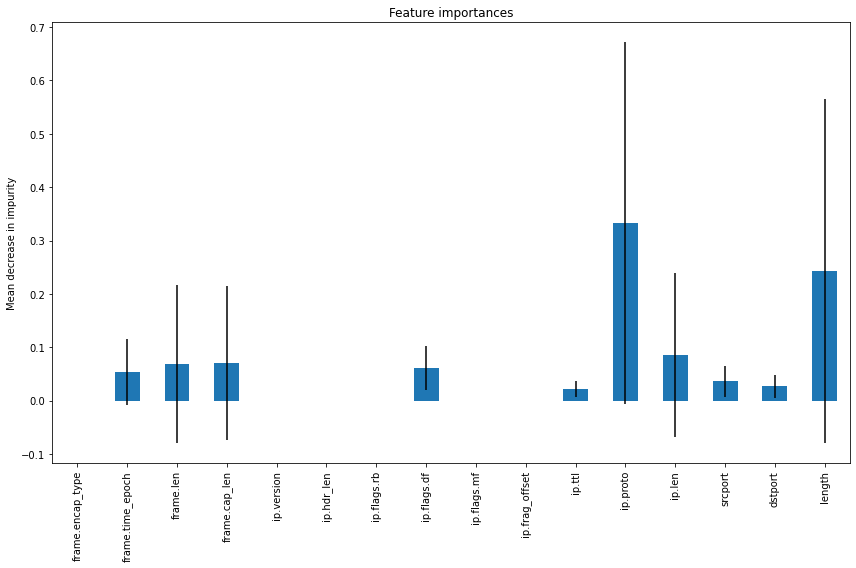

CPU times: user 921 ms, sys: 209 ms, total: 1.13 s
Wall time: 378 ms


In [162]:
%%time

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

features = list(clean_dataset.columns)
classifier_importances = pd.Series(importances, index=features)
print(classifier_importances)

fig, ax = plt.subplots()
classifier_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout(rect=(0, 0, 2, 2))
plt.show()


Gradient boosting


In [163]:
%%time

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "GradientBoostingClassifier"))

print(classification_report(Y_test, predictions))
score = model.score(X_test, Y_test) * 100
metrics["GradientBoosting"] = {"Accuracy": score}
print("Accuracy: {0}%".format(score))

try:
    scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
    print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
    metrics["GradientBoosting"].update({"CVAccuracy": mean(score)})
except:
    metrics["GradientBoosting"].update({"CVAccuracy": 0})


/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


Model predicted non quic packet:  [0]
Model predicted quic packet:  [0]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    211712
           1       0.99      1.00      0.99    335345

    accuracy                           0.99    547057
   macro avg       0.99      0.99      0.99    547057
weighted avg       0.99      0.99      0.99    547057

Accuracy: 99.11252392346684%
CPU times: user 2min 22s, sys: 3.83 s, total: 2min 26s
Wall time: 2min 37s


NaiveBayes

In [164]:
%%time

from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

model = BernoulliNB()
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "NaiveBayes"))

print(classification_report(Y_test, predictions))
score = model.score(X_test, Y_test) * 100
metrics["NaiveBayes"] = {"Accuracy": score}
print("Accuracy: {0}%".format(score))

try:
    scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
    print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
    metrics["NaiveBayes"].update({"CVAccuracy": mean(score)})
except:
    metrics["NaiveBayes"].update({"CVAccuracy": 0})

/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


Model predicted non quic packet:  [1]
Model predicted quic packet:  [0]
              precision    recall  f1-score   support

           0       0.98      0.20      0.33    211712
           1       0.66      1.00      0.80    335345

    accuracy                           0.69    547057
   macro avg       0.82      0.60      0.56    547057
weighted avg       0.78      0.69      0.62    547057

Accuracy: 68.80325084954583%
CPU times: user 5.31 s, sys: 1.27 s, total: 6.58 s
Wall time: 6.3 s


KNN Algorithm


In [165]:
%%time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

model = KNeighborsClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

# Not quic packet
print("Model predicted non quic packet: ", model.predict([[1,1644570362.781311,1474,1474,4,20,0,1,0,0,57,6,1460,5986,61023,32]]))
# Quic packet
print("Model predicted quic packet: ", model.predict([[1,1644570363.992292,87,87,4,20,0,0,0,0,64,17,73,54983,443,53]]))

# Save the model to file.
joblib.dump(model, path.join("models", "KNeighborsClassifier"))

print(classification_report(Y_test, predictions))
score = model.score(X_test, Y_test) * 100
metrics["KNN"] = {"Accuracy": score}
print("Accuracy: {0}%".format(score))

try:
    scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
    print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
    metrics["KNN"].update({"CVAccuracy": mean(score)})
    # print(scores)
except:
    metrics["KNN"].update({"CVAccuracy": 0})

/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-classifier/quic/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Model predicted non quic packet:  [0]
Model predicted quic packet:  [0]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    211712
           1       1.00      1.00      1.00    335345

    accuracy                           1.00    547057
   macro avg       1.00      1.00      1.00    547057
weighted avg       1.00      1.00      1.00    547057

Accuracy: 99.76638631806192%
CPU times: user 14h 23min 26s, sys: 6h 42min 10s, total: 21h 5min 36s
Wall time: 1d 9h 56min 6s


Plot accuracy


LogisticRegression                  61.29982798867394%
DecisionTree                        99.98501070272386%
RandomForest                        99.96618268297453%
GradientBoosting                    99.11252392346684%
NaiveBayes                          68.80325084954583%
KNN                                 99.76638631806192%


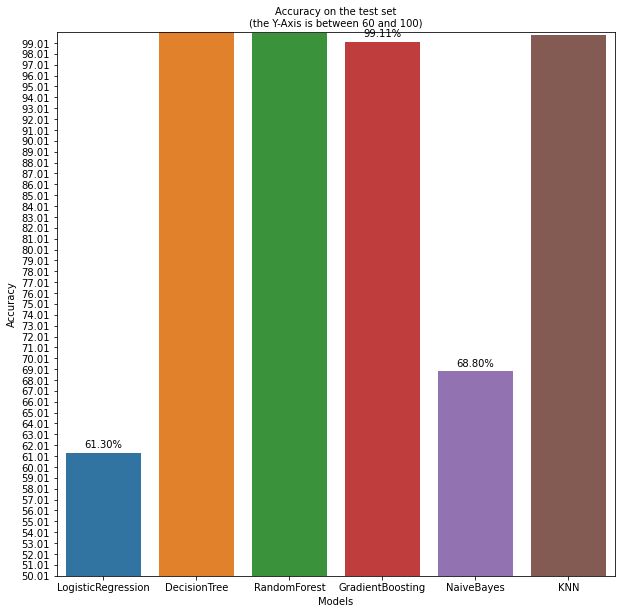

In [166]:
ticks = []
accuracy = []
models_accuracy = []
# print(metrics)
for k, v in metrics.items():
    accuracy.append(v["Accuracy"])
    models_accuracy.append([k, v["Accuracy"]])
    print("{0:<35} {1}%".format(k, v["Accuracy"]))

df_acc = pd.DataFrame(models_accuracy)
df_acc.columns = ["Models", "Accuracy"]

plt.figure(figsize=(10, 10))
g = sns.barplot(x="Models", y="Accuracy", data=df_acc)
for i in range(0, 100):
    val = i + 0.01
    ticks.append(val)
g.set_yticks(ticks)
g.set_yticklabels(ticks)

plt.title("Accuracy on the test set\n(the Y-Axis is between 60 and 100)", fontsize=10)
plt.ylim(50, 100)
for i, p in enumerate(g.patches):
    percentage = "{:.2f}%".format(accuracy[i])
    x = p.get_x() + (p.get_width() / 2)
    y = p.get_height() + 0.5
    g.annotate(percentage, (x, y), ha="center")

plt.show()


Plot cross-validation accuracy

LogisticRegression                  61.29982798867394%
DecisionTree                        99.98501070272386%
RandomForest                        99.96618268297453%
GradientBoosting                    0%
NaiveBayes                          0%
KNN                                 0%


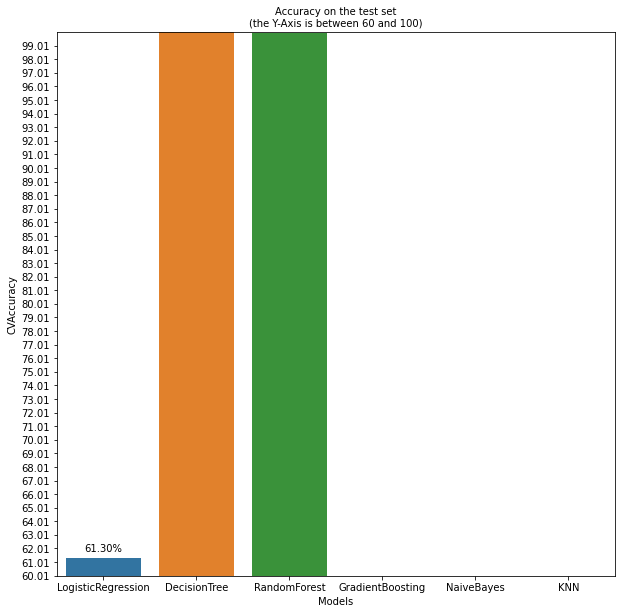

In [167]:
ticks = []
accuracy = []
models_accuracy = []

for k, v in metrics.items():
    try:
        accuracy.append(v["CVAccuracy"])
        models_accuracy.append([k, v["CVAccuracy"]])
        print("{0:<35} {1}%".format(k, v["CVAccuracy"]))

    except KeyError:
        accuracy.append(10.30)
        models_accuracy.append(10.30)
        print("{0:<35} {1}%".format(k, 01.03))
        continue


df_acc = pd.DataFrame(models_accuracy)
df_acc.columns = ["Models", "CVAccuracy"]

plt.figure(figsize=(10, 10))
g = sns.barplot(x="Models", y="CVAccuracy", data=df_acc)
for i in range(0, 100):
    val = i + 0.01
    ticks.append(val)
g.set_yticks(ticks)
g.set_yticklabels(ticks)

plt.title("Accuracy on the test set\n(the Y-Axis is between 60 and 100)", fontsize=10)
plt.ylim(60, 100)
for i, p in enumerate(g.patches):
    percentage = "{:.2f}%".format(accuracy[i])
    x = p.get_x() + (p.get_width() / 2)
    y = p.get_height() + 0.5
    g.annotate(percentage, (x, y), ha="center")

plt.show()
